In [ ]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import numpy as np
import os
import matplotlib.pyplot as plt
import difflib
import seaborn as sns
from matplotlib.patches import Patch

def extract_and_save_event_data(event_file):
    # 加载 TensorBoard 事件文件
    event_acc = EventAccumulator(event_file)
    event_acc.Reload()
    
    # 定义要提取的标签
    tags = [
        "losses/value_loss",
        "losses/policy_loss",
        "losses/entropy",
        "losses/old_approx_kl",
        "losses/approx_kl",
        "losses/clipfrac",
        "losses/explained_variance",
        "charts/learning_rate",
        "charts/SPS",
        "charts/episodic_return",
        "charts/episodic_length",
        "plasticity/dormant_units",
        "plasticity/active_units",
        "plasticity/stable_rank",
        "plasticity/effective_rank",
        "plasticity/feature_norm",
        "plasticity/feature_var",
        "plasticity/weight_magnitude",
        "plasticity/l2_norm_difference",
        "plasticity/grad_norm",
        "plasticity/policy_entropy",
    ]
    
    # 初始化存储数据的字典
    data = {tag: [] for tag in tags}
    steps = {tag: [] for tag in tags}
    
    # 遍历所有标签并提取数据
    for tag in tags:
        if tag in event_acc.Tags()["scalars"]:
            events = event_acc.Scalars(tag)
            # steps[tag] = [event.step for event in events]
            data[tag] = np.array([event.value for event in events])
        else:
            print(f"Warning: {event_file}, Tag {tag} not found in the event file.")
    
    return data

def smooth_tensorboard(values, smooth_factor=0.6):
    smoothed_values = np.zeros_like(values)
    num_runs, num_points = values.shape

    for i in range(num_runs):
        last_value = values[i, 0]
        smoothed_values[i, 0] = last_value
        for j in range(1, num_points):
            smoothed_value = last_value * smooth_factor + (1 - smooth_factor) * values[i, j]
            smoothed_values[i, j] = smoothed_value
            last_value = smoothed_value

    return smoothed_values

def sliding_window_smooth(values, window_size=5):
    num_runs, num_points = values.shape
    new_num_points = num_points // window_size # Number of windows per run
    smoothed_values = np.zeros((num_runs, new_num_points))

    for i in range(num_runs):
        for j in range(new_num_points):
            # Compute the average of each non-overlapping window
            start_idx = j * window_size
            end_idx = start_idx + window_size
            smoothed_values[i, j] = np.mean(values[i, start_idx:end_idx])

    return smoothed_values


In [2]:
methods = ['ca', 'dff', 'l2n', 'ln', 'nap', 
        #    'pi', 'pr', 
        'redo', 'rl', 'rr', 'snp', 
        #    'trac'
        'vanilla'
           ]
names = ['CReLU Activation', 'Deep Fourier Features', 'L2 Normalization', 'Layer Normalization', 'Normalize and Project', 
        #  'Plasticity Injection', 'Parseval Regularization', 
        'ReDo', 'Resetting Layer', 'Regenerative Regularization', 'Shrink and Perturb', 
        #  'TRAC'
        'Vanilla'
         ]


root = '../logs/std_ppo_craftax'

all_methods_data = {}
for method in methods:
    for dir in os.listdir(root):
        if method in dir:
            file = os.path.join(root, dir)
            folder = os.listdir(file)[0]
            folder = os.path.join(file, folder)
            event_file = difflib.get_close_matches("events.out.tfevents", os.listdir(folder), 1, 0.1)[0]
            event_file = os.path.join(folder, event_file)
            all_methods_data[method] = extract_and_save_event_data(event_file)

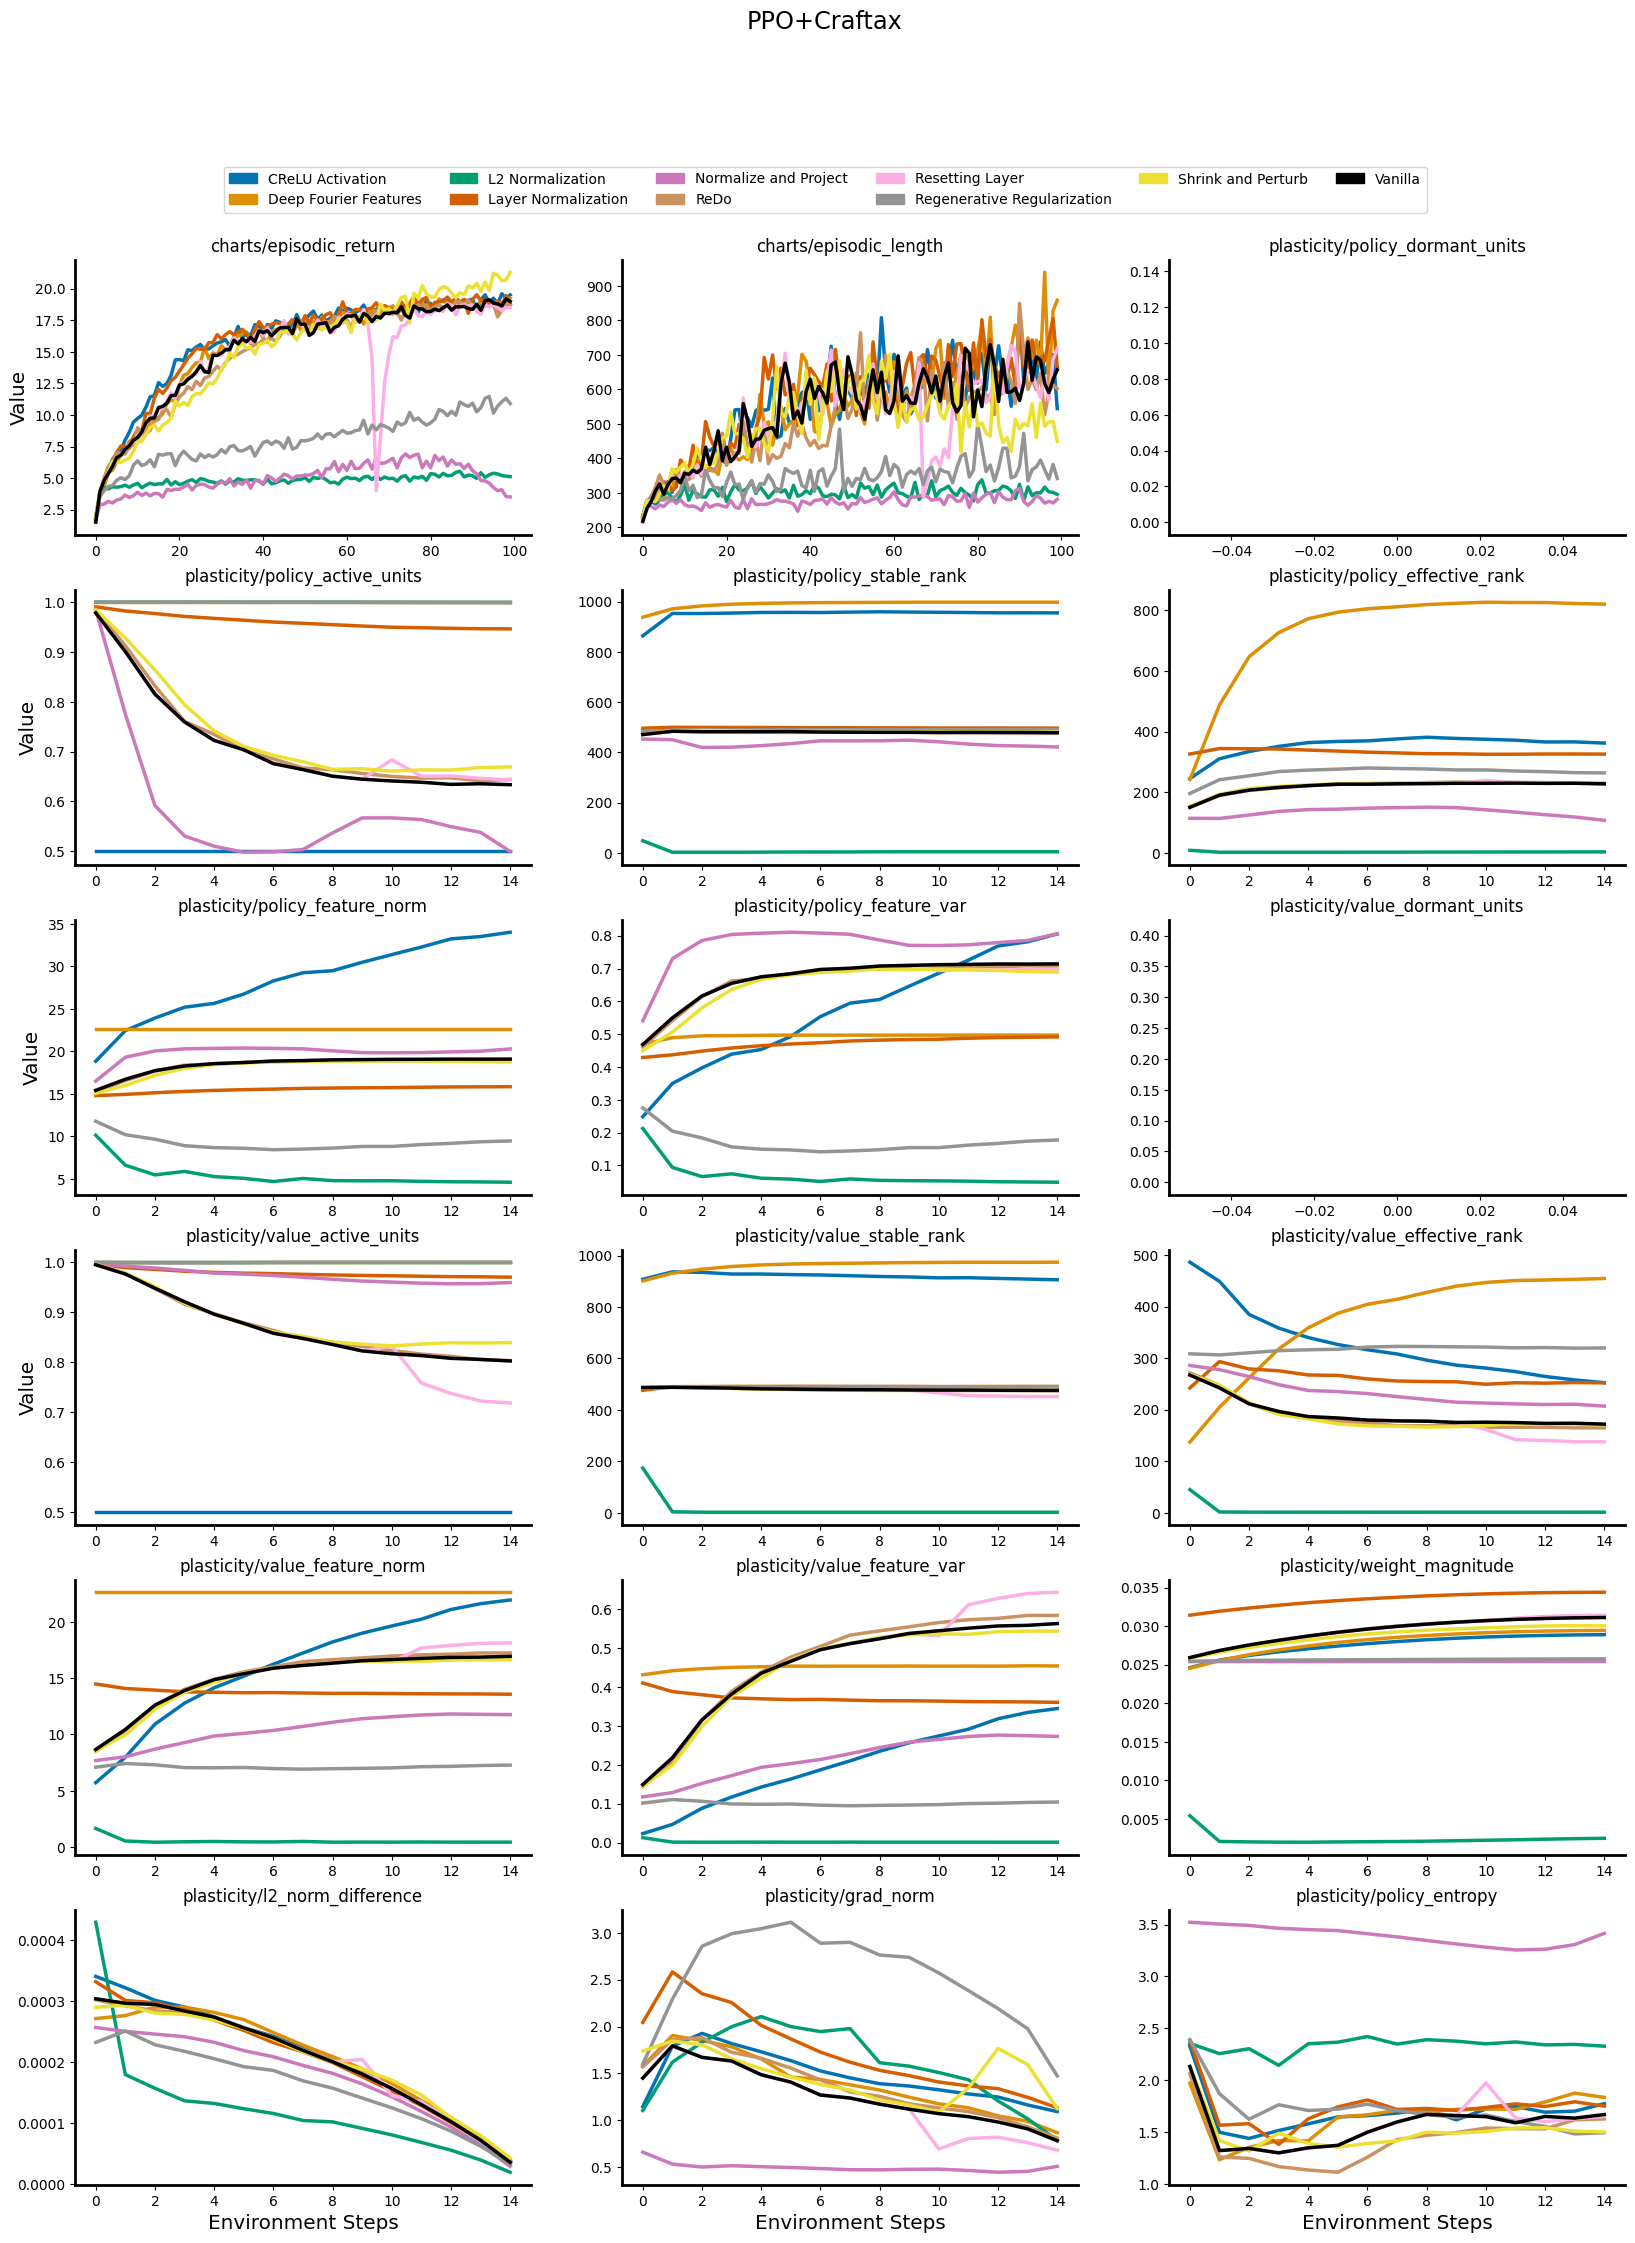

In [ ]:
metrics = [
    'charts/episodic_return',
    'charts/episodic_length',
    "plasticity/dormant_units",
    "plasticity/active_units",
    "plasticity/stable_rank",
    "plasticity/effective_rank",
    "plasticity/feature_norm",
    "plasticity/feature_var",
    "plasticity/weight_magnitude",
    "plasticity/l2_norm_difference",
    "plasticity/grad_norm",
    "plasticity/policy_entropy",]

colors = sns.color_palette("colorblind", len(methods)-1)
colors.append('k')
# create color patches
patches = [Patch(color=colors[i], label=names[i]) for i in range(len(methods)-1)]
patches.append(Patch(color='k', label=names[-1]))

fig, axes = plt.subplots(6, 3, figsize=(20, 25))
for i, m in enumerate(metrics):
    ax = axes[i // 3, i % 3]
    for j, method in enumerate(methods):
        data = all_methods_data[method][m]
        data = np.expand_dims(data, axis=0)
        data = sliding_window_smooth(data, 100)[0]
        ax.plot(data, label=names[j], color=colors[j], linewidth=2.5)
        # if method == 'vanilla':
        #     ax.hlines(data[-1], 0, len(methods)-1, label=names[j], color='k', linewidth=2.5, linestyle='--')
        # else:
        #     ax.bar(j, data[-1], label=names[j], color=colors[j])
    ax.set_title(m)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    # ax.set_ylim(0, 1)
    if i >= 15:
        ax.set_xlabel('Environment Steps', fontsize='x-large')
    if i in [0, 3, 6, 9]:
        ax.set_ylabel('Value', fontsize='x-large')

# set title for the entire figure
fig.suptitle('PPO+Procgen', fontsize='xx-large')
fig.legend(patches, names, loc='upper center', ncol=6, bbox_to_anchor=(0.5, 0.92))